In [ ]:
import pylab as pl

import jax.numpy as np
from numpy.random import randn
import pytest
from numpy.testing import assert_allclose
from jax import random

from jaxrk.rkhs import CovOp, Cdo, Cmo, FiniteOp, FiniteVec, multiply, inner, SpVec, CombVec, RolloutSpVec
from jaxrk.kern import (GaussianKernel, SplitDimsKernel, PeriodicKernel)
from jaxrk.utilities.array_manipulation import all_combinations
from sklearn.datasets import make_moons
from copy import copy

In [ ]:
x = np.linspace(0, 40, 400).reshape((-1, 1))
y = np.sin(x) -(0.1*(x-20))**2 + randn(len(x)).reshape((-1, 1)) * 0.2
out_kern = GaussianKernel(0.5)

pl.scatter(x.T, y.T)

In [ ]:
spv = SpVec(out_kern, np.hstack((x, y)), np.array([len(x)]), use_subtrajectories = True)

In [ ]:
for dist in ("linear", "gen_gauss", "poly"):
    spv.use_inner = dist
    inn = spv.inner()
    pl.figure()
    for i in range(100, 401, 100):
        pl.plot(inn[i], label=str(i))
    pl.legend(loc="best", title="reference traj # points")
    pl.title(dist)
    pl.xlabel("compared traj # points")
    pl.ylabel("kernel value")

In [ ]:
def plot_pred(mean_var, x, y, points_per_split = 1):
    if points_per_split == 1:
        rep_x = x
    else:
        rep_x = np.repeat(x, points_per_split, axis=0)
        
    pl.plot(x[200:].flatten(), mean_var.T[0].flatten(), color="red")
    pl.scatter(rep_x.T[:200], y.T[:200 * points_per_split].flatten(), color="green")
    pl.scatter(rep_x.T[200:], y.T[200 * points_per_split:].flatten(), color="green")
    sd = np.sqrt(mean_var.T[1].flatten())
    pl.fill_between(x[200:].flatten(), mean_var.T[0].flatten() + sd, mean_var.T[0].flatten() - sd, color="red", alpha=0.2)


In [ ]:
refervec = FiniteVec(out_kern, np.linspace(y.min() - 4, y.max() + 4, 6000)[:, None])
invec_gg = SpVec(out_kern, np.hstack((x[:-1], y[:-1])), np.array([len(x) - 1]), use_subtrajectories = True, use_inner="gen_gauss")
invec_lin = SpVec(out_kern, np.hstack((x[:-1], y[:-1])), np.array([len(x) - 1]), use_subtrajectories = True, use_inner="linear")
invec_pol = SpVec(out_kern, np.hstack((x[:-1], y[:-1])), np.array([len(x) - 1]), use_subtrajectories = True, use_inner="poly")
outvec = FiniteVec(out_kern, y[1:])

Text(0.5, 1.0, 'Generalized gaussian kernel on process embeddings')

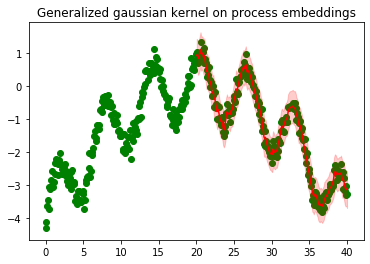

In [49]:
cd_gg = Cmo(invec_gg, outvec)
mean_var_gg = np.array(multiply(cd_gg, invec_gg).normalized().get_mean_var()).T
plot_pred(mean_var_gg[199:], x, y)
pl.title("Generalized gaussian kernel on process embeddings")

In [61]:
cmo_gg = Cmo(invec_gg, outvec)
cmo_lin = Cmo(invec_lin, outvec)
cmo_pol = Cmo(invec_pol, outvec)

In [59]:
from tqdm import tqdm


samps = {}
for (use_inner, cmo) in [("gen_gauss", cmo_gg), ("linear", cmo_lin), ("poly", cmo_pol), ]:
    print(use_inner)
    invec_inf = SpVec(out_kern, np.hstack((x[:200], y[:200])), np.array([200]), use_subtrajectories = False, use_inner="gen_gauss")
    ro = RolloutSpVec(cmo, invec_inf, 1)
    rval = []
    for i in tqdm(range(1, 210)):
        new_point = cur_ro.current_outp_emb.point_representant()
        rval.append(new_point)
        cur_ro.update(new_point)
    samps[use_inner] = rval

100%|██████████| 209/209 [02:07<00:00,  1.63it/s]


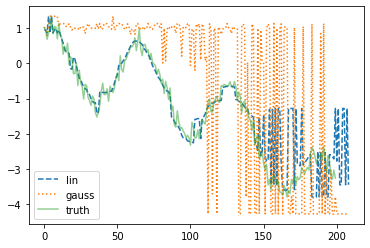

In [60]:
rv_gauss = np.array(rval[:1]).squeeze()
# prefactor of 600. This is very brittle and highly dependend on the prefactor
pl.plot(rv_lin, "--", label = "lin") 
pl.plot(rv_gauss, ":", label = "gauss")
#pl.fill_between(range(300), rv.mean(0)-rv.std(0), rv.mean(0)+rv.std(0), alpha=0.5)
pl.plot(y.flatten()[200:], label="truth", alpha=0.5)
pl.legend(loc="best")

In [ ]:
pl.legend?

In [ ]:
g_mix = cd_gg.inp_feat.k(cd_gg.inp_feat.inspace_points, invec_inf.inspace_points)
g_op = cd_gg.inp_feat.k(cd_gg.inp_feat.inspace_points)
g_iv = cd_gg.inp_feat.k(invec_inf.inspace_points)

In [ ]:
for g in g_mix, g_op, g_iv:
    print(np.any(np.isinf(g_mix)), np.any(np.isnan(g_mix)))

In [ ]:
#efficient
from tqdm import tqdm

boundary = 200
invec_inf = SpVec(out_kern, np.hstack((x[:boundary], y[:boundary])), np.array([boundary]), use_subtrajectories = False, use_inner="gen_gauss")
inc = (current_hist.inspace_points[1:, 0] -  current_hist.inspace_points[:-1, 0]).mean()

start_emb = multiply(cd_gg, invec_inf)
k = boundary
rval = []
for j in range(2):
    current_hist = invec_inf
    rval.append([])
    print(j)
    emb = start_emb
    cur_idx = invec_inf.inspace_points[-1, 0]
    
    for i in (range(300)):
        rval[-1].append(emb.point_representant())
        cur_idx = cur_idx + inc
        new_point = np.array((cur_idx, rval[-1][-1][-1])).reshape(1,-1)
        upd = multiply(cd_gg, SpVec(out_kern, new_point.reshape((1, -1)), np.array([1]), use_subtrajectories = False, use_inner="gen_gauss"))
        emb = emb.updated((emb.prefactors * k + upd.prefactors)/(k + 1))
        k = k + 1

In [ ]:
a = start_emb
b = multiply(cd_gg, SpVec(out_kern, np.hstack((x[:200], y[:200])), np.array([200]), use_subtrajectories = False, use_inner="gen_gauss"))

In [ ]:
a.prefactors - b.prefactors

In [ ]:
rv

In [ ]:
cd_lin = Cdo(invec_lin, outvec, refervec)
mean_var_lin = np.array(multiply(cd_lin, invec_lin).normalized().get_mean_var()).T
plot_pred(mean_var_lin[199:], x, y)
pl.title("Linear kernel on process embeddings")

In [ ]:
cd_pol = Cdo(invec_pol, outvec, refervec)
mean_var_pol = np.array(multiply(cd_pol, invec_pol).normalized().get_mean_var()).T
plot_pred(mean_var_pol[199:], x, y)
pl.title("Polynomial kernel on process embeddings")